<a href="https://colab.research.google.com/github/epodkwan/growthfunction/blob/main/notebooks/bsplinetrainer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install flax

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [36]:
from functools import partial
import sys, os

os.environ['TF_CPP_MIN_LOG_LEVEL']='3'
os.environ['XLA_PYTHON_CLIENT_PREALLOCATE']='false'

sys.path.append('/content/drive/MyDrive/Colab Notebooks/growth/')
from conf import Configuration
from cosmology import Cosmology, SimpleLCDM, growth_integ
from growth_mlp import Growth_MLP

from typing import Sequence
import random
import statistics
import jax
import optax
import numpy as np
import jax.numpy as jnp
from jax import jit, vmap, grad
from flax import linen as nn
from flax.training import train_state, checkpoints
import matplotlib.pyplot as plt

In [37]:
def npy_loader(path):
    return jnp.load(path)

In [38]:
class SimpleMLP(nn.Module):
    features:Sequence[int]
    nodes:int

    @nn.compact
    def __call__(self, inputs):
        x=inputs
        for feat in self.features:
            x=nn.Dense(feat)(x)
            x=nn.elu(x)
        t=nn.Dense(nodes-2)(x)
        c=nn.Dense(nodes+1)(x)
        t=jnp.concatenate([jnp.zeros((t.shape[0], 4)), jnp.cumsum(jax.nn.softmax(t), axis=1), jnp.ones((t.shape[0], 4))], axis=1)
        c=jnp.concatenate([jnp.zeros((c.shape[0], 1)), c], axis=1)
        return t, c

In [39]:
@jit
def _deBoorVectorized(x, t, c):
    p=3
    k=jnp.digitize(x, t)-1
    d=[c[j+k-p] for j in range(0, p+1)]
    for r in range(1, p+1):
        for j in range(p, r-1, -1):
            alpha=(x-t[j+k-p])/(t[j+1+k-r]-t[j+k-p])
            d[j]=(1.0-alpha)*d[j-1]+alpha*d[j]
    return d[p]

deBoor=vmap(_deBoorVectorized, in_axes=(None, 0, 0))

In [40]:
@jit
def eval_func(params, x, a):
    t, c=model.apply(params, x)
    preds=deBoor(jnp.clip(a, 0, 0.99999), t, c)
    return preds

In [41]:
@jit
def D(a, cosmo):
    conf=cosmo.conf 
    a=jnp.asarray(a, dtype=conf.cosmo_dtype)
    D=a * jnp.interp(a, conf.growth_a, cosmo.growth[0][0])
    D1=1 * jnp.interp(1., conf.growth_a, cosmo.growth[0][0])
    return D/D1

In [42]:
@jit
def objective_a(params, conf, a_test):
    omegam, omegak, w0, wa=params
    cosmo=SimpleLCDM(conf, Omega_m=omegam, Omega_k=omegak, w_0=w0, w_a=wa)
    cosmo=growth_integ(cosmo)
    obj=D(jnp.asarray(a_test), cosmo)
    return obj

In [43]:
obj_grad_a=jit(grad(objective_a, argnums=(0)))
nc=32
cell_size=8
growth_anum=512
conf=Configuration(cell_size=cell_size, mesh_shape=(nc, )*3, growth_anum=growth_anum)
layer_sizes=[64, 64]
nodes=8
learning_rate=1e-5
epochs=50000
model=SimpleMLP(features=layer_sizes, nodes=nodes)
temp=jnp.array([[1]])
params=model.init(jax.random.PRNGKey(0), temp)
tx=optax.adam(learning_rate=learning_rate)
opt_state=tx.init(params)
target=100

In [10]:
@jit
def mse_loss(params, x, y_ref, a):
    preds=eval_func(params, x, a)
    diff=preds-y_ref
    return jnp.mean(diff*diff)

In [11]:
@jit
def train_step(opt_state, params, x, y_ref, a):
    loss, grads=jax.value_and_grad(mse_loss, argnums=0)(params, x, y_ref, a)
    updates, opt_state=tx.update(grads, opt_state)
    params=optax.apply_updates(params, updates)
    return loss, params, opt_state

In [12]:
@jit
def epoch_step(x_train, y_train, params, opt_state, order, a):
    order=jax.random.permutation(jax.random.PRNGKey(i), order)
    train_loss=0
    for j in range(25):
        x_batch=x_train[order[32*j:32*(j+1)], :]
        y_batch=y_train[order[32*j:32*(j+1)], :]
        loss, params, opt_state=train_step(opt_state, params, x_batch, y_batch, a)
        train_loss=train_loss+loss
    return train_loss, params

In [13]:
from google.colab import drive
drive.mount('/content/drive/')
os.chdir("/content/drive/My Drive/Colab Notebooks/")

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [14]:
input_data=npy_loader("./lindata"+str(target)+"/cosmo.npy")
input_result=npy_loader("./lindata"+str(target)+"/combined.npy")
a=npy_loader("./lindata"+str(target)+"/999.npy")[0, :]
# input_result=jnp.log(raw_input_result)
x_train=input_data[0:800].reshape(800, -1)
y_train=input_result[0:800, :]
x_validate=input_data[800:900, 0].reshape(100, -1)
y_validate=input_result[800:900, :]

1000 1.5245496353004753e-06
2000 6.189105845811733e-07
3000 3.2541103361807855e-07
4000 2.418426515620903e-07
5000 1.957543041475235e-07
6000 1.6798475890665793e-07
7000 1.4563090556498963e-07
8000 1.249427999909726e-07
9000 1.0550958048603669e-07
10000 9.20675325884163e-08
11000 8.38953771963307e-08
12000 7.070331606899555e-08
13000 6.256330901439916e-08
14000 5.608209516243132e-08
15000 5.0698539442989945e-08
16000 4.7393567145690016e-08
17000 5.007093800706766e-08
18000 4.8334455329726445e-08
19000 4.733125036773681e-08
20000 4.66139536698624e-08
21000 4.755587739043238e-08
22000 4.782497535679393e-08
23000 4.153006132140786e-08
24000 4.156926415209797e-08
25000 3.920049507546039e-08
26000 3.7604569982136274e-08
27000 3.5957231728101805e-08
28000 3.473530720016709e-08
29000 3.357090129561425e-08
30000 3.222086843480313e-08
31000 3.19425610415193e-08
32000 3.1052782575845314e-08
33000 3.0280767063202164e-08
34000 2.9611581485721474e-08
35000 2.904907343827976e-08
36000 2.878738629153

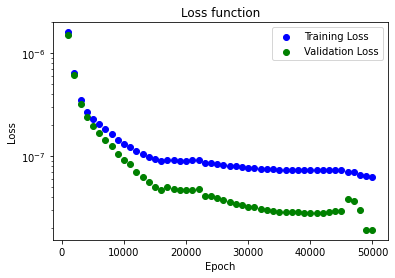

In [15]:
os.chdir("/content/drive/My Drive/Colab Notebooks/elu/")
order=jnp.arange(800)
for i in range(epochs):
    train_loss, params=epoch_step(x_train, y_train, params, opt_state, order, a)
    if i % 1000 == 999:
        train_loss=train_loss/25
        validate_loss=mse_loss(params, x_validate, y_validate, a)
        print((i+1), validate_loss)
        plt.scatter((i+1), train_loss, c='b')
        plt.scatter((i+1), validate_loss, c='g')
print("Training ended")
state=train_state.TrainState.create(apply_fn=model.apply, params=params, tx=tx)
checkpoints.save_checkpoint(ckpt_dir=("./"+str(target)+"/"), target=state, step=0, overwrite=True)
plt.yscale('log')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss function")
plt.legend(["Training Loss", "Validation Loss"])
plt.savefig("./"+str(target)+"loss.png")

In [16]:
params_class={}
for order in range(1, 3):
    for deriv in range(3):
        key="{}{}".format(order, deriv)
        params_class[key]=params
growth_fn=Growth_MLP(model, params_class)
growth_integ_jit=jit(growth_integ)
omega_m_test=0.1
omega_k_test=0.
w_0_test=-1.
w_a_test=0.
a_test=jnp.linspace(0., 1., 100)
epsilon=1e-3

In [17]:
@jit
def predict(cosmo, a):
    return growth_fn(cosmo, a)[0, 0]

In [18]:
@jit
def gradient_at(cosmo, a):
    value1, gradient=jax.value_and_grad(predict, 0)(jnp.array([cosmo]), a)
    return value1, gradient

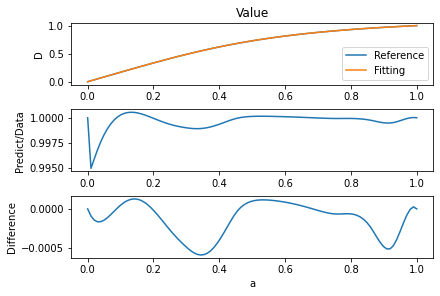

In [25]:
cosmo_test=SimpleLCDM(conf, Omega_m=omega_m_test, Omega_k=omega_k_test, w_0=w_0_test, w_a=w_a_test)
cosmo_test=growth_integ_jit(cosmo_test)
d_data=D(a_test, cosmo_test)
d_test=growth_fn(jnp.array([[omega_m_test]]), a_test).reshape(-1)
# d_test=predict(params, jnp.array([[omega_m_test]]), a_test)
discrepancy=(abs(d_test)+epsilon)/(abs(d_data)+epsilon)
fig, (ax1, ax2, ax3)=plt.subplots(3, 1, constrained_layout=True)
ax1.plot(a_test, d_data, label="Reference")
ax1.plot(a_test, d_test, label="Fitting")
ax1.set_ylabel("D")
ax1.legend()
ax1.set_title("Value")
ax2.plot(a_test, discrepancy)
ax2.set_ylabel("Predict/Data")
ax2.ticklabel_format(useOffset=False)
ax3.plot(a_test, d_test-d_data)
ax3.set_ylabel("Difference")
ax3.set_xlabel("a")
plt.savefig("./"+str(target)+"value.png")

compile growth
compile boor
compile boor


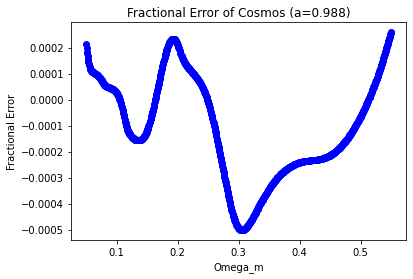

In [20]:
a_plot=[]
med=[]
mean_error=[]
std=[]
for i in range(10):
    plt.clf()
    temp=[]
    for j in range(1000):
        d_data=input_result[j, i*28]/input_result[j, -1]
        d_test=growth_fn(jnp.array([[input_data[j, 0]]]), a[i*28]).reshape(-1)
        temp.append(((abs(d_test)+epsilon)/(abs(d_data)+epsilon)-1).item())
        plt.scatter(input_data[j, 0], temp[-1], c='b')
    plt.xlabel("Omega_m")
    plt.ylabel("Fractional Error")
    plt.title("Fractional Error of Cosmos (a="+str(np.round(a[i*28].item(), 3))+")")
    plt.savefig("./"+str(target)+"error"+str(i)+".png")
    a_plot.append(a[i*28].item())
    med.append(statistics.median(temp))
    mean_error.append(statistics.mean(temp))
    std.append(statistics.stdev(temp))

<Figure size 432x288 with 0 Axes>

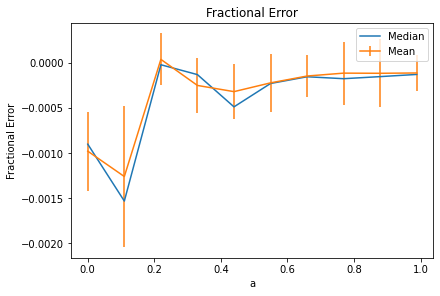

In [21]:
plt.clf()
fig, ax=plt.subplots(constrained_layout=True)
ax.plot(a_plot, med, label="Median")
ax.errorbar(a_plot, mean_error, std, label="Mean")
# ax.set_xscale('log')
ax.set_xlabel("a")
ax.set_ylabel("Fractional Error")
ax.set_title("Fractional Error")
ax.legend()
plt.savefig("./"+str(target)+"centralerror.png")

<Figure size 432x288 with 0 Axes>

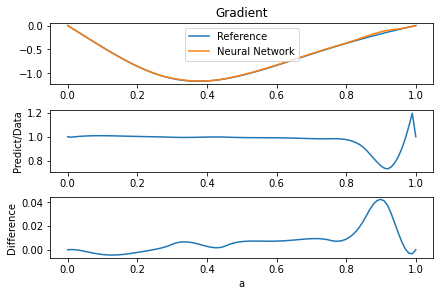

In [44]:
plt.clf()
cosmo_test=[omega_m_test, omega_k_test, w_0_test, w_a_test]
grad_ref=[]
grad_test=[]
for i in a_test:
    value, grad=gradient_at([omega_m_test], i)
    grad_test.append(grad)
    grad_ref.append(obj_grad_a(cosmo_test, conf, i)[0])
grad_ref=np.array(grad_ref).reshape(-1)
grad_test=np.array(grad_test).reshape(-1)
discrepancy=(abs(grad_test)+epsilon)/(abs(grad_ref)+epsilon)
fig, (ax1, ax2, ax3)=plt.subplots(3, 1, constrained_layout=True)
ax1.plot(a_test, grad_ref, label="Reference")
ax1.plot(a_test, grad_test, label="Neural Network")
ax1.legend()
ax1.set_title("Gradient")
ax2.plot(a_test, discrepancy)
ax2.set_ylabel("Predict/Data")
ax2.ticklabel_format(useOffset=False)
ax3.plot(a_test, grad_test-grad_ref)
ax3.set_ylabel("Difference")
ax3.set_xlabel("a")
plt.savefig("./"+str(target)+"gradient.png")

In [ ]:
max_error=[]
for i in range(100):
    if (input_data[i, 0]>=0.1) and (input_data[i, 0]<=0.5):
        discrepancy=[]
        for j in a_test[25:]:
            value, grad_test=gradient_at([input_data[i, 0]], j)
            grad_ref=obj_grad_a([input_data[i, 0], omega_k_test, w_0_test, w_a_test], conf, j)[0]
            discrepancy.append(abs((abs(grad_test)+epsilon)/(abs(grad_ref)+epsilon)-1))
        # for j in range(225, 256):
        #     value1, gradient_pred=gradient_at(i, a[j])
        #     discrepancy.append(gradient_pred[0, 0]-gradient_test[j])
        max_error=jnp.max(np.array(discrepancy))
        plt.scatter(input_data[i, 0], max_error, color='b')
plt.title("Max Error")
plt.xlabel("Omega_m")
plt.ylabel("Fractional Error")
plt.ticklabel_format(useOffset=False)
plt.savefig("./"+str(target)+"maxerror.png")

0.5387699498927752
0.5751618873227101
0.2261814024368468
0.09402464447244441
0.4451401157384298
0.28513216500520766
0.26990531033831855
0.0690347407206664
0.51725487323209
0.7079347355734646
0.5598170269896792
0.44414483073167865
0.08003093031793163
0.1500536139482559
0.5067819657180272
0.369125723560793
0.5098630430814307
0.46731472118373696
0.06733295864523581
0.1477637322948251
1.185480294030059
0.4894136536409728
0.10681257528212207
0.2743835883340521
0.4448412929365252
0.147057235918861
0.12076388529493443
0.5126878609667356
0.340017172585505
0.46055483420803744
0.4573213006065038
0.5124303255876148
0.08611996907412611
0.4016485481385894
0.29516578976322816
1.1698393916581518
0.47578318674211206
0.33182897658084665
0.4756686959022537
0.5472051429305964
0.3171810309340609
0.14694754137081367
0.21090273631548118
0.6997327277600558
0.533271862254004
0.9852446268819222
0.42455971195742703
1.251977824177699
0.09000225901406811
0.7049185568544463
0.3363794617147564
0.7169709509969937
0.

In [ ]:
# drive.flush_and_unmount()